In [1]:
# Decide whether or not running on Kaggle
import os
KAGGLE_RUN = True
if os.path.isdir('/home/ubuntu'):
    KAGGLE_RUN = False
    
if KAGGLE_RUN:
    model_name = 'model5/model5.txt'
else:
    model_name = 'model5.txt'
    
# Libraries
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score

from collections import defaultdict
import lightgbm as lgb
import random
if not KAGGLE_RUN:
    import sys
    sys.path.insert(0, './input')
    import local_work
import riiideducation

# Boto3 Setup and Download Files
if not KAGGLE_RUN:
    local_work = local_work.local_work()
    local_work.download_riiid_files()
    
# Column definitions    
train_cols = ['user_id', 'content_id', 'content_type_id', 'answered_correctly'
             ,'prior_question_elapsed_time', 'prior_question_had_explanation']
target = 'answered_correctly'

# Load data
if not KAGGLE_RUN:
    df_train = local_work.get_train_data(train_cols)
    #df_train = local_work.get_train_data(train_cols, nrow=10000000)
    df_questions = local_work.get_questions_data()
else:
    import datatable as dt
    df_train = dt.fread('../input/riiid-test-answer-prediction/train.csv'
                        ,columns=set(train_cols)).to_pandas()
    df_questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv'
                                ,usecols=[0, 3]
                                ,dtype={'question_id': 'int16', 'part': 'int8'}
                               )
    

# Cleaning function
def clean(df, target, df_questions, is_train):
    # Only keep question rows
    df = df[df['content_type_id'] == 0].reset_index(drop=True)
    
    # Assume False if NA (Only for first question ? )
    df['prior_question_had_explanation'].fillna(False, inplace=True)  
    
    # Alter columns types
    tmp = {'user_id': 'int32'
            ,'content_id': 'int16'
            ,target: 'int8'
            ,'prior_question_elapsed_time': 'float32' 
            ,'prior_question_had_explanation': 'bool'
            }
    if not is_train:
        del tmp[target]
    df = df.astype(tmp)
    
    # Merge questions
    df = pd.merge(df, df_questions, left_on='content_id', right_on='question_id', how='left')
        
    return(df)

# Feature Engineering function
def do_fe(df
          ,is_train
          ,content_agg=None
          ,user_sum_dict=None
          ,user_count_dict=None
          ,content_sum_dict=None
          ,content_count_dict=None
         ):
    '''
    TODO: - Does it make sense to update content_agg in the testing set?
    '''

    if is_train:
        # Get information on the previous correctness and count
        df['prev_correct'] = df.groupby('user_id')[target].shift()
        prev_cum = df.groupby('user_id')['prev_correct'].agg(['cumsum', 'cumcount'])
        df.drop(columns=['prev_correct'], inplace=True)
        
        # FE Columns
        df['user_correctness'] = prev_cum['cumsum'] / prev_cum['cumcount']
        df['user_question_num'] = prev_cum['cumcount']
        # Drop rows here because of memory problems
        df = df.groupby('user_id').tail(24).reset_index(drop=True)
        df['content_count'] = df['content_id'].map(content_agg['count']).astype('int32')
        df['content_avg_correctness'] = df['content_id'].map(content_agg['sum'] / content_agg['count'])
    
    else:
        # Initialize user/content sums
        user_sum = np.zeros(len(df), dtype=np.int16)
        user_count = np.zeros(len(df), dtype=np.int16)
        content_sum = np.zeros(len(df), dtype=np.int32)
        content_count = np.zeros(len(df), dtype=np.int32)

        # Get user/content sums
        for i, (user_id, content_id) in enumerate(zip(df['user_id'].values, df['content_id'].values)):
            user_sum[i] = user_sum_dict[user_id]
            user_count[i] = user_count_dict[user_id]
            content_sum[i] = content_sum_dict[content_id]
            content_count[i] = content_count_dict[content_id]

        df['user_correctness'] = user_sum / user_count # Causes warning when user_count 0
        df['user_question_num'] = user_count
        df['content_count'] = content_count
        df['content_avg_correctness'] = content_sum / content_count
    
    return(df)

# Make user and content aggs
user_agg = df_train.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = df_train.groupby('content_id')[target].agg(['sum', 'count'])

clean
fe
drop valid
[LightGBM] [Info] Number of positive: 3602877, number of negative: 2933798
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3868
[LightGBM] [Info] Number of data points in the train set: 6536675, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551179 -> initscore=0.205435
[LightGBM] [Info] Start training from score 0.205435
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.752768	valid_1's auc: 0.735232
[100]	training's auc: 0.754215	valid_1's auc: 0.736554
[150]	training's auc: 0.754896	valid_1's auc: 0.737018
[200]	training's auc: 0.755491	valid_1's auc: 0.737429
[250]	training's auc: 0.755889	valid_1's auc: 0.737602
[300]	training's auc: 0.756328	valid_1's auc: 0.73779
[350]	training's auc: 0.756

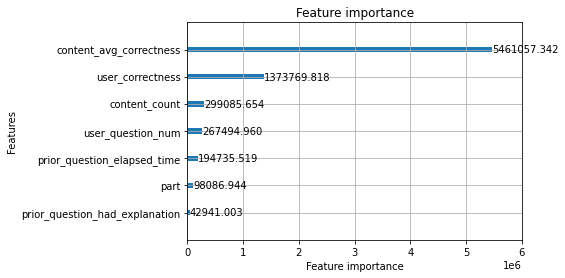

In [2]:
# Define features
features = ['user_question_num'
            ,'prior_question_elapsed_time'
            ,'prior_question_had_explanation'
            ,'user_correctness'
            ,'part'
            ,'content_avg_correctness'
            ,'content_count'
]
    
if not KAGGLE_RUN:
    # Clean
    df_train = clean(df_train
                     ,target
                     ,df_questions
                     ,is_train=True
                    )

    # Feature Engineer
    df_train = do_fe(df_train, is_train=True, content_agg = content_agg)
    
    # Keep only the most recent rows for each user
    #df_train = df_train.groupby('user_id').tail(18).reset_index(drop=True)
    #print('drop rows')
    
    # Define validation set as the 6 most recent interactions
    df_valid = df_train.groupby('user_id').tail(6)
    df_train.drop(df_valid.index, inplace=True)
    
    # Build and save model
    model = local_work.make_model(df_train, df_valid, target, features)
    model.save_model(f'./output/' + model_name)
    lgb.plot_importance(model, importance_type='gain')
    
else:
    model = lgb.Booster(model_file='/kaggle/input/' + model_name)

In [3]:
c = 0
# Setup dicts
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

# Make env
env = riiideducation.make_env()
iter_test = env.iter_test()
df_prior_test = None

# Make predictions
for (df_test, df_sample_prediction) in iter_test:
    
    if df_prior_test is not None:
        # Attach whether or not users answered correctly
        df_prior_test[target] = eval(df_test['prior_group_answers_correct'].iloc[0])
        df_prior_test = df_prior_test[df_prior_test[target] != -1].reset_index(drop=True)

        user_ids = df_prior_test['user_id'].values
        content_ids = df_prior_test['content_id'].values
        targets = df_prior_test[target].values

        # Update user and content dictionaries
        for user_id, content_id, answered_correctly in zip(df_prior_test['user_id'].values
                                                           ,df_prior_test['content_id'].values
                                                           ,df_prior_test[target].values):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    # Make a copy of df_test for the next iteration
    df_prior_test = df_test.copy()
 
    # Clean
    df_test = clean(df_test
                     ,target
                     ,df_questions
                     ,is_train=False
                    )
    
    # Feature engineer
    df_test = do_fe(df_test
                    ,is_train=False
                    ,user_sum_dict = user_sum_dict
                    ,user_count_dict = user_count_dict
                    ,content_sum_dict = content_sum_dict
                    ,content_count_dict = content_count_dict
                    )
    
    # Make prediction
    df_test[target] = model.predict(df_test[features])
    env.predict(df_test[['row_id', target]])
    
    c += 1
    
print("Finished")
print(c)

Finished
4


/home/ubuntu/kaggle_riiid/venv/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
